In [1]:
import warnings
import os
import pickle

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sn

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

# %matplotlib qt
# warnings.filterwarnings("ignore")  # supress warnings from matplotlib


In [2]:
# set variables
global use_seed
use_seed = False
threshold = 5  # possible values are: 1, 2, 5, 10
# set the number of epochs you want to train the network (default = 300)
epochs = 300 # 400
save_fig = False  # set True to save the plots

global use_trainable_out
use_trainable_out = False
global use_trainable_tc
use_trainable_tc = False
global use_dropout
use_dropout = False
global batch_size
batch_size = 128  # 512
global lr
lr = 0.0015


In [3]:
# create folder to safe plots later
if save_fig:
    path = '../plots'
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)

In [4]:
# check for available GPU and distribute work

share_GPU = False # True if multiple GPUs are to be used to share memory
gpu_sel = 1 # selected (single) GPU to be used if memory is not to be shared
gpu_mem_frac = 0.6 # memory fraction limit

global device
if (torch.cuda.device_count()>=1) & (share_GPU):
    gpu_av = [torch.cuda.is_available() for ii in range(torch.cuda.device_count())]
    print("Detected {} GPUs. The load will be shared.".format(torch.cuda.device_count()))
    for gpu in range(len(gpu_av)):
        if True in gpu_av:
            if gpu_av[gpu_sel]:
                device = torch.device("cuda:"+str(gpu))
                print("Selected GPUs: {}" .format("cuda:"+str(gpu)))
            else:
                device = torch.device("cuda:"+str(gpu_av.index(True)))
        else:
            device = torch.device("cpu")
            print("No GPU detected. Running on CPU.")
elif (torch.cuda.device_count()>=1) & (not share_GPU):
    print("Multiple GPUs detected but single GPU selected. Setting up the simulation on {}".format("cuda:"+str(gpu_sel)))
    device = torch.device("cuda:"+str(gpu_sel))
    torch.cuda.set_per_process_memory_fraction(gpu_mem_frac, device=device) # decrese or comment out memory fraction if more is available (the smaller the better)
else:
    if torch.cuda.is_available():
        print("Single GPU detected. Setting up the simulation there.")
        device = torch.device("cuda")
        # thr 1: None, thr 2: 0.8, thr 5: 0.5, thr 10: None
        torch.cuda.set_per_process_memory_fraction(gpu_mem_frac, device=device) # decrese or comment out memory fraction if more is available (the smaller the better)
    else:
        device = torch.device("cpu")
        print("No GPU detected. Running on CPU.")

Multiple GPUs detected but single GPU selected. Setting up the simulation on cuda:1


In [5]:
# use fixed seed for reproducible results
if use_seed:
    seed = 42 # "Answer to the Ultimate Question of Life, the Universe, and Everything"
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    print("Seed set to {}".format(seed))

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)


In [6]:
dtype = torch.float

In [7]:
letters = ['Space', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [8]:
def load_and_extract_events(params, file_name, ratios=[0.8, 0, 0.2], taxels=None, letter_written=letters):

    if np.sum(ratios) != 1:
        raise ValueError('Check the correct ratios are used: got sum > 1')
    
    # max_time = int(54*25) #ms
    max_time = int(350*10) #ms
    time_bin_size = int(params['time_bin_size']) # ms
    global time
    time = range(0,max_time,time_bin_size)
    # Increase max_time to make sure no timestep is cut due to fractional amount of steps
    global time_step
    time_step = time_bin_size*0.001
    data_steps = len(time)
    
    """
    infile = open(file_name, 'rb')
    data_dict = pickle.load(infile)
    infile.close()
    # Extract data
    data = []
    labels = []
    bins = 1000  # [ms] 
    nchan = len(data_dict[1]['events']) # number of channels/sensors
    """
    dataset = pd.read_pickle(file_name)
    data_dict = dataset.copy()
    data = []
    labels = []
    bins = 1000  # [ms] 
    nchan = len(data_dict['events'][1]) # number of channels/sensors
    for i, sample in enumerate(data_dict['events']):
        dat = (sample[:])
        events_array = np.zeros([nchan,round((max_time/time_bin_size)+0.5),2])
        for taxel in range(len(dat)):
            for event_type in range(len(dat[taxel])):
                if dat[taxel][event_type]:
                    indx = bins*(np.array(dat[taxel][event_type]))
                    indx = np.array((indx/time_bin_size).round(), dtype=int)
                    events_array[taxel,indx,event_type] = 1
        if taxels != None:
            events_array = np.reshape(np.transpose(events_array, (1,0,2))[:,taxels,:],(events_array.shape[1],-1))
            selected_chans = 2*len(taxels)
        else:
            events_array = np.reshape(np.transpose(events_array, (1,0,2)),(events_array.shape[1],-1))
            selected_chans = 2*nchan
        data.append(events_array)
        labels.append(letter_written.index(data_dict['letter'][i]))

    data = torch.tensor(data, dtype=dtype)    
    labels = torch.tensor(labels,dtype=torch.long)

    train, val, test = ratios

    if val > 0:
        split_1 = 1-train
        split_2 = 1- val/(val+test)
        x_train, x_valtest, y_train, y_valtest = train_test_split(data, labels, test_size=split_1, shuffle=True, stratify=labels, random_state=42)
        x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=split_2, shuffle=True, stratify=y_valtest, random_state=42)
        ds_train = TensorDataset(x_train,y_train)
        ds_val = TensorDataset(x_val,y_val)
        ds_test = TensorDataset(x_test,y_test)
    else:
        x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=test, shuffle=True, stratify=labels, random_state=42)
        ds_train = TensorDataset(x_train,y_train)
        ds_val = []
        ds_test = TensorDataset(x_test,y_test)
    
    return ds_train, ds_val, ds_test, labels, selected_chans, data_steps

In [9]:
def run_snn(inputs, layers):

    if use_trainable_out and use_trainable_tc:
        w1, w2, v1, alpha1, beta1, alpha2, beta2, out_scale, out_offset = layers
    elif use_trainable_tc:
        w1, w2, v1, alpha1, beta1, alpha2, beta2 = layers
    elif use_trainable_out:
        w1, w2, v1, out_scale, out_offset = layers
    else:
        w1, w2, v1 = layers
    if use_dropout:
        dropout = nn.Dropout(p = 0.25) # using dropout on n % of spikes
    if use_trainable_tc:
        alpha1, beta1 = torch.abs(alpha1), torch.abs(beta1)
        alpha2, beta2 = torch.abs(alpha2), torch.abs(beta2)

    bs = inputs.shape[0]
    
    h1 = torch.einsum(
        "abc,cd->abd", (inputs.tile((nb_input_copies,)), w1))
    if use_dropout:
        h1 = dropout(h1)
    if use_trainable_tc:
        spk_rec, mem_rec = recurrent_layer.compute_activity_tc(bs, nb_hidden, h1, v1, alpha1, beta1, nb_steps)
    else:
        spk_rec, mem_rec = recurrent_layer.compute_activity(bs, nb_hidden, h1, v1, nb_steps)
    
    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    if use_dropout:
        h2 = dropout(h2)
    if use_trainable_tc:
        s_out_rec, out_rec = feedforward_layer.compute_activity_tc(bs, nb_outputs, h2, alpha2, beta2, nb_steps)
    else:
        s_out_rec, out_rec = feedforward_layer.compute_activity(bs, nb_outputs, h2, nb_steps)

    if use_trainable_out:
        # trainable output spike scaling
        # mean_firing_rate = torch.div(torch.sum(s_out_rec,1), s_out_rec.shape[1]) # mean firing rate
        # s_out_rec = mean_firing_rate*layers[5] + layers[6]
        s_out_rec = torch.sum(s_out_rec, 1)*out_scale + \
            out_offset  # sum spikes

    other_recs = [mem_rec, spk_rec, out_rec]
    layers_update = layers

    return s_out_rec, other_recs, layers_update


In [10]:
def load_layers(file, map_location, requires_grad=True, variable=False):

    if variable:
        lays = file
        for ii in lays:
            ii.requires_grad = requires_grad
    else:
        lays = torch.load(file, map_location=map_location)
        for ii in lays:
            ii.requires_grad = requires_grad
    return lays


In [11]:
def train(params, dataset, lr=0.0015, nb_epochs=300, opt_parameters=None, layers=None, dataset_test=None):

    if (opt_parameters != None) & (layers != None):
        parameters = opt_parameters  # The paramters we want to optimize
        layers = layers
    elif (opt_parameters != None) & (layers == None):
        parameters = opt_parameters
        if use_trainable_out and use_trainable_tc:
            layers = [w1, w2, v1, alpha1, beta1, alpha2, out_scale, out_offset]
        elif use_trainable_out:
            layers = [w1, w2, v1, out_scale, out_offset]
        elif use_trainable_tc:
            layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
        else:
            layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2,]
    elif (opt_parameters == None) & (layers != None):
        if use_trainable_out and use_trainable_tc:
            layers = [w1, w2, v1, alpha1, beta1, alpha2,
                        beta2, out_scale, out_offset]
        elif use_trainable_out:
            layers = [w1, w2, v1, out_scale, out_offset]
        elif use_trainable_tc:
            layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
        else:
            layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
        layers = layers
    elif (opt_parameters == None) & (layers == None):
        if use_trainable_out and use_trainable_tc:
            parameters = [w1, w2, v1, alpha1, beta1, alpha2,
                        beta2, out_scale, out_offset]
            layers = [w1, w2, v1, alpha1, beta1, alpha2,
                        beta2, out_scale, out_offset]
        elif use_trainable_out:
            parameters = [w1, w2, v1, out_scale, out_offset]
            layers = [w1, w2, v1, out_scale, out_offset]
        elif use_trainable_tc:
            parameters = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
            layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
        else:
            parameters = [w1, w2, v1, alpha1, beta1,
                        alpha2, beta2]
            layers = [w1, w2, v1, alpha1, beta1,
                        alpha2, beta2]

    if use_seed:
        g = torch.Generator()
        g.manual_seed(42)
        generator = DataLoader(
                               dataset,
                               batch_size=128,
                               shuffle=True,
                               num_workers=2,
                               worker_init_fn=seed_worker,
                               generator=g,
                              )

    else:
        generator = DataLoader(
                               dataset,
                               batch_size=128,
                               shuffle=True,
                               num_workers=2,
                              )

    # The log softmax function across output units
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()  # The negative log likelihood loss function

    # The optimization loop
    loss_hist = []
    accs_hist = [[], []]
    for e in range(nb_epochs):
        # learning rate decreases over epochs
        optimizer = torch.optim.Adamax(parameters, lr=lr, betas=(0.9, 0.995))
        # if e > nb_epochs/2:
        #     lr = lr * 0.9
        local_loss = []
        # accs: mean training accuracies for each batch
        accs = []
        for x_local, y_local in generator:
            x_local, y_local = x_local.to(device), y_local.to(device)
            spks_out, recs, layers_update = run_snn(x_local, layers)
            # [mem_rec, spk_rec, out_rec]
            _, spk_rec, _ = recs

            # with output spikes
            if use_trainable_out:
                m = spks_out
            else:
                m = torch.sum(spks_out, 1)  # sum over time
            # cross entropy loss on the active read-out layer
            log_p_y = log_softmax_fn(m)

            # TODO change to loop!
            # Here we can set up our regularizer loss
            # reg_loss = params['reg_spikes']*torch.mean(torch.sum(spks1,1)) # L1 loss on spikes per neuron (original)
            # L1 loss on total number of spikes (hidden layer 1)
            reg_loss = params['reg_spikes']*torch.mean(torch.sum(spk_rec, 1))
            # L1 loss on total number of spikes (output layer)
            # reg_loss += params['reg_spikes']*torch.mean(torch.sum(spks_out, 1))
            # print("L1: ", reg_loss)
            # reg_loss += params['reg_neurons']*torch.mean(torch.sum(torch.sum(spks1,dim=0),dim=0)**2) # e.g., L2 loss on total number of spikes (original)
            # L2 loss on spikes per neuron (hidden layer 1)
            reg_loss += params['reg_neurons'] * \
                torch.mean(torch.sum(torch.sum(spk_rec, dim=0), dim=0)**2)
            # L2 loss on spikes per neuron (output layer)
            # reg_loss += params['reg_neurons'] * \
            #     torch.mean(torch.sum(torch.sum(spks_out, dim=0), dim=0)**2)
            # print("L1 + L2: ", reg_loss)

            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())

            # compare to labels
            _, am = torch.max(m, 1)  # argmax over output units
            tmp = np.mean((y_local == am).detach().cpu().numpy())
            accs.append(tmp)

        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)

        # mean_accs: mean training accuracy of current epoch (average over all batches)
        mean_accs = np.mean(accs)
        accs_hist[0].append(mean_accs)

        # Calculate test accuracy in each epoch
        if dataset_test is not None:
            test_acc = compute_classification_accuracy(
                params,
                dataset_test,
                layers=layers_update,
                early=True
            )
            accs_hist[1].append(test_acc)  # only safe best test

        if dataset_test is None:
            # save best training
            if mean_accs >= np.max(accs_hist[0]):
                best_acc_layers = []
                for ii in layers_update:
                    best_acc_layers.append(ii.detach().clone())
        else:
            # save best test
            if np.max(test_acc) >= np.max(accs_hist[1]):
                best_acc_layers = []
                for ii in layers_update:
                    best_acc_layers.append(ii.detach().clone())

        # plt.figure("live plot")
        # plt.title("Epoch: {}" .format(e+1))
        # plt.subplot(1, 2, 1)
        # plt.plot(range(1, len(accs_hist[0])+1),
        #          100*np.array(accs_hist[0]), color='blue')
        # plt.plot(range(1, len(accs_hist[1])+1),
        #          100*np.array(accs_hist[1]), color='orange')
        # plt.xlabel("Epoch")
        # plt.ylabel("Accuracy (%)")
        # plt.ylim(0, 105)
        # plt.legend(["Training", "Test"], loc='lower right')
        # plt.subplot(1, 2, 2)
        # plt.plot(range(1, len(loss_hist)+1), np.array(loss_hist), color='blue')
        # plt.xlabel("Epoch")
        # plt.ylabel("Loss")
        # plt.legend(["Training"], loc='lower right')
        # # to avoid clearing last plot
        # if (e != epochs-1):
        #     plt.draw()
        #     plt.pause(0.1)
        #     plt.cla()
        # else:
        #     plt.close("live plot")

        print("Epoch {}/{} done. Train accuracy: {:.2f}%, Test accuracy: {:.2f}%, Loss: {:.5f}.".format(
            e + 1, nb_epochs, accs_hist[0][-1]*100, accs_hist[1][-1]*100, loss_hist[-1]))

    return loss_hist, accs_hist, best_acc_layers


In [12]:
def build_and_train(params, ds_train, ds_test, epochs=epochs):

    global nb_input_copies
    # Num of spiking neurons used to encode each channel
    nb_input_copies = params['nb_input_copies']

    # Network parameters
    global nb_inputs
    nb_inputs = nb_channels*nb_input_copies
    global nb_outputs
    nb_outputs = len(np.unique(labels))
    global nb_hidden
    nb_hidden = 450
    global nb_steps
    nb_steps = data_steps

    tau_mem = params['tau_mem']  # ms
    tau_syn = tau_mem/params['tau_ratio']
    
    if not use_trainable_tc:
        global alpha
        global beta
    alpha = float(np.exp(-time_step/tau_syn))
    beta = float(np.exp(-time_step/tau_mem))

    fwd_weight_scale = params['fwd_weight_scale']
    rec_weight_scale = fwd_weight_scale*params['weight_scale_factor']

    # Spiking network
    layers = []
    
    # recurrent layer
    w1, v1 = recurrent_layer.create_layer(
        nb_inputs, nb_hidden, fwd_weight_scale, rec_weight_scale)

    # readout layer
    w2 = feedforward_layer.create_layer(
        nb_hidden, nb_outputs, fwd_weight_scale)
    
    if use_trainable_tc:
        # time constants
        alpha1, beta1 = trainable_time_constants.create_time_constants(
            nb_hidden, alpha, beta, use_trainable_tc)

        alpha2, beta2 = trainable_time_constants.create_time_constants(
            nb_outputs, alpha, beta, use_trainable_tc)


    layers.append(w1), layers.append(w2), layers.append(v1)
    if use_trainable_tc:
        layers.append(alpha1), layers.append(beta1), layers.append(alpha2), layers.append(beta2)

    if use_trainable_out:
        # include trainable output for readout layer (linear: y = out_scale * x + out_offset)
        out_scale = torch.empty(
            (nb_outputs),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.ones_(out_scale)
        layers.append(out_scale)
        out_offset = torch.empty(
            (nb_outputs),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.zeros_(out_offset)
        layers.append(out_offset)

    layers_init = []
    for ii in layers:
        layers_init.append(ii.detach().clone())

    if use_trainable_out and use_trainable_tc:
        opt_parameters = [w1, w2, v1, alpha1, beta1, alpha2, beta2, out_scale, out_offset]
    elif use_trainable_tc:
        opt_parameters = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
    elif use_trainable_out:
        opt_parameters = [w1, w2, v1, out_scale, out_offset]
    else:
        opt_parameters = [w1, w2, v1]

    # a fixed learning rate is already defined within the train function, that's why here it is omitted
    loss_hist, accs_hist, best_layers = train(
        params, ds_train, lr=lr, nb_epochs=epochs, opt_parameters=opt_parameters, layers=layers, dataset_test=ds_test)

    # best training and test at best training
    acc_best_train = np.max(accs_hist[0])  # returns max value
    acc_best_train = acc_best_train*100
    idx_best_train = np.argmax(accs_hist[0])  # returns index of max value
    acc_test_at_best_train = accs_hist[1][idx_best_train]*100

    # best test and training at best test
    acc_best_test = np.max(accs_hist[1])
    acc_best_test = acc_best_test*100
    idx_best_test = np.argmax(accs_hist[1])
    acc_train_at_best_test = accs_hist[0][idx_best_test]*100

    # TODO track time constants!!!
    print("Final results: ")
    print("Best training accuracy: {:.2f}% and according test accuracy: {:.2f}% at epoch: {}".format(
        acc_best_train, acc_test_at_best_train, idx_best_train+1))
    print("Best test accuracy: {:.2f}% and according train accuracy: {:.2f}% at epoch: {}".format(
        acc_best_test, acc_train_at_best_test, idx_best_test+1))
    print("------------------------------------------------------------------------------------\n")
    return loss_hist, accs_hist, best_layers


In [13]:
def compute_classification_accuracy(params, dataset, layers=None, early=False):
    """ Computes classification accuracy on supplied data in batches. """

    if use_seed:
        g = torch.Generator()
        g.manual_seed(42)
        generator = DataLoader(
                               dataset,
                               batch_size=128,
                               shuffle=True,
                               num_workers=2,
                               worker_init_fn=seed_worker,
                               generator=g,
                              )

    else:
        generator = DataLoader(
                               dataset,
                               batch_size=128,
                               shuffle=True,
                               num_workers=2,
                              )
                              
    accs = []

    for x_local, y_local in generator:
        x_local, y_local = x_local.to(device), y_local.to(device)
        if layers == None:
            if use_trainable_out and use_trainable_tc:
                layers = [w1, w2, v1, alpha1, beta1, alpha2,
                          beta2, out_scale, out_offset]
            elif use_trainable_out:
                layers = [w1, w2, v1, out_scale, out_offset]
            elif use_trainable_tc:
                layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
            else:
                layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
            spks_out, _, _ = run_snn(x_local, layers)
        else:
            spks_out, _, _ = run_snn(x_local, layers)
        # with output spikes
        if use_trainable_out:
            m = spks_out
        else:
            m = torch.sum(spks_out, 1)  # sum over time
        _, am = torch.max(m, 1)     # argmax over output units
        # compare to labels
        tmp = np.mean((y_local == am).detach().cpu().numpy())
        accs.append(tmp)

    return np.mean(accs)


In [14]:
def ConfusionMatrix(dataset, save, layers=None, labels=letters):

    generator = DataLoader(dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)
    accs = []
    trues = []
    preds = []
    for x_local, y_local in generator:
        x_local, y_local = x_local.to(device), y_local.to(device)
        if layers == None:
            if use_trainable_out and use_trainable_tc:
                layers = [w1, w2, v1, alpha1, beta1, alpha2,
                          beta2, out_scale, out_offset]
            elif use_trainable_out:
                layers = [w1, w2, v1, out_scale, out_offset]
            elif use_trainable_tc:
                layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
            else:
                layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
            spks_out, _, _ = run_snn(x_local, layers)
        else:
            spks_out, _, _ = run_snn(x_local, layers)
        # with output spikes
        if use_trainable_out:
            m = spks_out
        else:
            m = torch.sum(spks_out, 1)  # sum over time
        _, am = torch.max(m, 1)     # argmax over output units
        # compare to labels
        tmp = np.mean((y_local == am).detach().cpu().numpy())
        accs.append(tmp)
        trues.extend(y_local.detach().cpu().numpy())
        preds.extend(am.detach().cpu().numpy())

    cm = confusion_matrix(trues, preds, normalize='true')
    cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[
                         jj for jj in labels])
    plt.figure(figsize=(12, 9))
    sn.heatmap(cm_df,
               annot=True,
               fmt='.1g',
               cbar=False,
               square=False,
               cmap="YlGnBu")
    plt.xlabel('\nPredicted')
    plt.ylabel('True\n')
    plt.xticks(rotation=0)
    if save:
        if use_trainable_out:
            plt.savefig("../plots/rsnn_1layers_train_tc_output_optimized_thr_" +
                        str(threshold) + "_cm.png", dpi=300)
        else:
            plt.savefig("../plots/rsnn_1layers_train_tc_thr_" +
                        str(threshold) + "_cm.png", dpi=300)
    else:
        plt.show()


In [15]:
def NetworkActivity(dataset, save, layers=None, labels=letters):

    generator = DataLoader(dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)
    accs = []
    trues = []
    preds = []
    for x_local, y_local in generator:
        x_local, y_local = x_local.to(device), y_local.to(device)
        if layers == None:
            if use_trainable_out and use_trainable_tc:
                layers = [w1, w2, v1, alpha1, beta1, alpha2,
                          beta2, out_scale, out_offset]
            elif use_trainable_out:
                layers = [w1, w2, v1, out_scale, out_offset]
            elif use_trainable_tc:
                layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
            else:
                layers = [w1, w2, v1, alpha1, beta1, alpha2, beta2]
            spks_out, recs, _ = run_snn(x_local, layers)
        else:
            spks_out, recs, _ = run_snn(x_local, layers)

        # [mem_rec, spk_rec, mem_rec2, spk_rec2, out_rec]
        _, spk_rec, _, spk_rec3, _ = recs

    nb_plt = 4
    gs = GridSpec(1, nb_plt)

    # hidden layer
    fig = plt.figure(figsize=(7, 3), dpi=150)
    plt.title("Hidden layer 1")
    for i in range(nb_plt):
        plt.subplot(gs[i])
        plt.imshow(spk_rec[i].detach().cpu().numpy().T,
                   cmap=plt.cm.gray_r, origin="lower")
        if i == 0:
            plt.xlabel("Time")
            plt.ylabel("Units")
        sn.despine()
    if save:
        if use_trainable_out:
            plt.savefig("../plots/rsnn_1layers_train_tc_output" +
                        "_thr_" + str(threshold) + "_rp_layer_1.png", dpi=300)
        else:
            plt.savefig("../plots/rsnn_1layers_train_tc_thr_" +
                        str(threshold) + "_rp_layer_1.png", dpi=300)

    # output layer
    fig = plt.figure(figsize=(7, 3), dpi=150)
    plt.title("Output layer")
    for i in range(nb_plt):
        plt.subplot(gs[i])
        plt.imshow(spks_out[i].detach().cpu().numpy().T,
                   cmap=plt.cm.gray_r, origin="lower")
        if i == 0:
            plt.xlabel("Time")
            plt.ylabel("Units")
        sn.despine()
    if save:
        if use_trainable_out:
            plt.savefig("../plots/rsnn_1layers_train_tc_output" +
                        "_thr_" + str(threshold) + "_rp_output_layer.png", dpi=300)
        else:
            plt.savefig("../plots/rsnn_1layers_train_tc_thr_" +
                        str(threshold) + "_rp_output_layer.png", dpi=300)
    else:
        plt.show()


In [16]:
# Load data and parameters
file_dir_data = '../../data/'
file_freq = 100 #40
file_type = 'data_braille_letters_th_'
#file_type = 'data_braille_letters_events_augmented_th'
file_thr = str(threshold)
file_name = file_dir_data + str(file_freq) + 'Hz/' + file_type + file_thr + '.pkl' #'_rpNull'

file_dir_params = '../parameters/'
param_filename = 'parameters_th' + str(threshold) + '.txt'
file_name_parameters = file_dir_params + param_filename
params = {}
with open(file_name_parameters) as file:
    for line in file:
        (key, value) = line.split()
        if key == 'time_bin_size' or key == 'nb_input_copies':
            params[key] = int(value)
        else:
            params[key] = np.double(value)


In [17]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """

    scale = params['scale']

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad


spike_fn = SurrGradSpike.apply


In [18]:
class feedforward_layer:
    '''
    class to initialize and compute spiking feedforward layer
    '''
    def create_layer(nb_inputs, nb_outputs, scale):
        ff_layer = torch.empty((nb_inputs, nb_outputs),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(ff_layer, mean=0.0, std=scale/np.sqrt(nb_inputs))
        return ff_layer
    
    def compute_activity(nb_input, nb_neurons, input_activity, nb_steps):
        syn = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        mem = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        out = torch.zeros((nb_input, nb_neurons), device=device, dtype=dtype)
        mem_rec = []
        spk_rec = []

        # Compute feedforward layer activity
        for t in range(nb_steps):
            mthr = mem-1.0
            out = spike_fn(mthr)
            rst_out = out.detach()

            new_syn = alpha*syn + input_activity[:,t]
            new_mem = (beta*mem + syn)*(1.0-rst_out)

            mem_rec.append(mem)
            spk_rec.append(out)

            mem = new_mem
            syn = new_syn

        # Now we merge the recorded membrane potentials into a single tensor
        mem_rec = torch.stack(mem_rec,dim=1)
        spk_rec = torch.stack(spk_rec,dim=1)
        return spk_rec, mem_rec
    
    def compute_activity_tc(nb_input, nb_neurons, input_activity, alpha, beta, nb_steps):
        syn = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        mem = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        out = torch.zeros((nb_input, nb_neurons), device=device, dtype=dtype)
        mem_rec = []
        spk_rec = []

        # Compute feedforward layer activity
        for t in range(nb_steps):
            mthr = mem-1.0
            out = spike_fn(mthr)
            rst_out = out.detach()

            new_syn = torch.abs(alpha)*syn + input_activity[:,t]
            new_mem = (torch.abs(beta)*mem + syn)*(1.0-rst_out)

            mem_rec.append(mem)
            spk_rec.append(out)

            mem = new_mem
            syn = new_syn

        # Now we merge the recorded membrane potentials into a single tensor
        mem_rec = torch.stack(mem_rec,dim=1)
        spk_rec = torch.stack(spk_rec,dim=1)
        return spk_rec, mem_rec


class recurrent_layer:
    '''
    class to initialize and compute spiking recurrent layer
    '''
    def create_layer(nb_inputs, nb_outputs, fwd_scale, rec_scale):
        ff_layer = torch.empty((nb_inputs, nb_outputs),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(ff_layer, mean=0.0, std=fwd_scale/np.sqrt(nb_inputs))
        
        rec_layer = torch.empty((nb_outputs, nb_outputs),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(rec_layer, mean=0.0, std=rec_scale/np.sqrt(nb_inputs))
        return ff_layer,  rec_layer
    
    def compute_activity(nb_input, nb_neurons, input_activity, layer, nb_steps):
        syn = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        mem = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        out = torch.zeros((nb_input, nb_neurons), device=device, dtype=dtype)
        mem_rec = []
        spk_rec = []

        # Compute recurrent layer activity
        for t in range(nb_steps):
            # input activity plus last step output activity
            h1 = input_activity[:,t] + torch.einsum("ab,bc->ac", (out, layer))
            mthr = mem-1.0
            out = spike_fn(mthr)
            rst = out.detach() # We do not want to backprop through the reset

            new_syn = alpha*syn + h1
            new_mem = (beta*mem + syn)*(1.0-rst)

            mem_rec.append(mem)
            spk_rec.append(out)
        
            mem = new_mem
            syn = new_syn

        # Now we merge the recorded membrane potentials into a single tensor
        mem_rec = torch.stack(mem_rec,dim=1)
        spk_rec = torch.stack(spk_rec,dim=1)
        return spk_rec, mem_rec
    
    def compute_activity_tc(nb_input, nb_neurons, input_activity, layer, alpha, beta, nb_steps):
        syn = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        mem = torch.zeros((nb_input,nb_neurons), device=device, dtype=dtype)
        out = torch.zeros((nb_input, nb_neurons), device=device, dtype=dtype)
        mem_rec = []
        spk_rec = []

        # Compute recurrent layer activity
        for t in range(nb_steps):
            # input activity plus last step output activity
            h1 = input_activity[:,t] + torch.einsum("ab,bc->ac", (out, layer))
            mthr = mem-1.0
            out = spike_fn(mthr)
            rst = out.detach() # We do not want to backprop through the reset

            new_syn = torch.abs(alpha)*syn + h1
            new_mem = (torch.abs(beta)*mem + syn)*(1.0-rst)

            mem_rec.append(mem)
            spk_rec.append(out)
        
            mem = new_mem
            syn = new_syn

        # Now we merge the recorded membrane potentials into a single tensor
        mem_rec = torch.stack(mem_rec,dim=1)
        spk_rec = torch.stack(spk_rec,dim=1)
        return spk_rec, mem_rec


class trainable_time_constants:
    def create_time_constants(nb_neurons, alpha_mean, beta_mean, trainable):
        alpha = torch.empty((nb_neurons),  device=device,
                             dtype=dtype, requires_grad=trainable)
        torch.nn.init.normal_(
            alpha, mean=alpha_mean, std=alpha_mean/10)
        
        beta = torch.empty((nb_neurons),  device=device,
                            dtype=dtype, requires_grad=trainable)
        torch.nn.init.normal_(
            beta, mean=beta_mean, std=beta_mean/10)
        return alpha, beta

### Train and test the network

In [19]:
acc_train_list = []
acc_test_list = []
max_epochs = 5
for epoch in range(max_epochs):
    # reload and shuffle data each epoch
    ds_train, _, ds_test, labels, nb_channels, data_steps = load_and_extract_events(
        params, file_name, letter_written=letters)

    if epoch == 0:
        print("Number of training data %i" % len(ds_train))
        print("Number of testing data %i" % len(ds_test))
        print("Number of outputs %i" % len(np.unique(labels)))
        print("Number of timesteps %i" % data_steps)
        print("Input duration %fs" % (data_steps*time_step))
        print("---------------------------\n")

    # initialize and train network
    loss_hist, acc_hist, best_layers = build_and_train(
        params, ds_train, ds_test, epochs=epochs)

    # safe overall best layer
    if epoch == 0:
        very_best_layer = best_layers
        best_acc = max(acc_hist[1])
    else:
        if max(acc_hist[1]) > best_acc:
            very_best_layer = best_layers
            best_acc = max(acc_hist[1])

    acc_train_list.append(acc_hist[0])
    acc_test_list.append(acc_hist[1])

print("*************************")
print("* Best: ", best_acc*100)
print("*************************")

/tmp/ipykernel_19024/910255790.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data = torch.tensor(data, dtype=dtype)


Number of training data 6480
Number of testing data 1620
Number of outputs 27
Number of timesteps 1167
Input duration 3.501000s
---------------------------

Epoch 1/300 done. Train accuracy: 9.19%, Test accuracy: 15.30%, Loss: 17.98430.
Epoch 2/300 done. Train accuracy: 15.37%, Test accuracy: 24.73%, Loss: 6.85765.
Epoch 3/300 done. Train accuracy: 32.10%, Test accuracy: 47.86%, Loss: 2.99233.
Epoch 4/300 done. Train accuracy: 43.05%, Test accuracy: 54.58%, Loss: 2.58211.
Epoch 5/300 done. Train accuracy: 52.77%, Test accuracy: 66.60%, Loss: 1.88018.
Epoch 6/300 done. Train accuracy: 62.40%, Test accuracy: 71.81%, Loss: 1.55787.
Epoch 7/300 done. Train accuracy: 68.97%, Test accuracy: 79.70%, Loss: 1.15863.
Epoch 8/300 done. Train accuracy: 76.64%, Test accuracy: 86.10%, Loss: 0.81050.
Epoch 9/300 done. Train accuracy: 82.22%, Test accuracy: 88.84%, Loss: 0.69791.
Epoch 10/300 done. Train accuracy: 85.07%, Test accuracy: 91.76%, Loss: 0.54818.
Epoch 11/300 done. Train accuracy: 87.39%,

### Let's plot the training curve and the confusion matrix

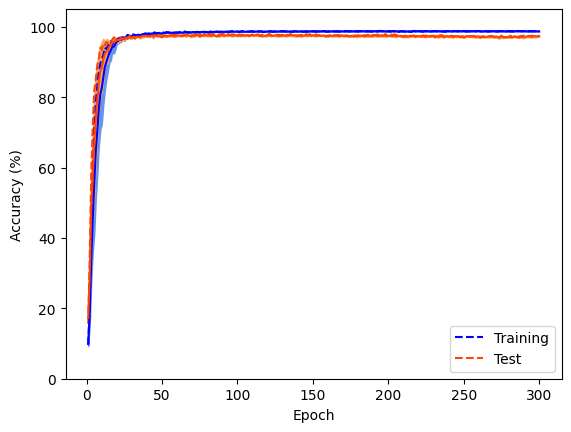

In [20]:
# calc mean and std
acc_mean_train = np.mean(acc_train_list, axis=0)
acc_std_train = np.std(acc_train_list, axis=0)
acc_mean_test = np.mean(acc_test_list, axis=0)
acc_std_test = np.std(acc_test_list, axis=0)
best_trial, best_val_idx = np.where(np.max(acc_test_list) == acc_test_list)
best_trial, best_val_idx = best_trial[0], best_val_idx[0]
plt.figure()
# plot best trial
plt.plot(range(1, len(acc_train_list[best_trial])+1), 100*np.array(
    acc_train_list[best_trial]), color='blue', linestyle='dashed')
plt.plot(range(1, len(acc_test_list[best_trial])+1), 100*np.array(
    acc_test_list[best_trial]), color='orangered', linestyle='dashed')
# plot mean and std
plt.plot(range(1, len(acc_mean_train)+1),
         100*np.array(acc_mean_train), color='blue')
plt.plot(range(1, len(acc_mean_test)+1), 100 *
         np.array(acc_mean_test), color='orangered')
plt.fill_between(range(1, len(acc_mean_train)+1), 100*(acc_mean_train+acc_std_train), 100*(
    acc_mean_train-acc_std_train), color='cornflowerblue')
plt.fill_between(range(1, len(acc_mean_test)+1), 100*(
    acc_mean_test+acc_std_test), 100*(acc_mean_test-acc_std_test), color='sandybrown')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim((0, 105))
plt.legend(["Training", "Test"], loc='lower right')
if save_fig:
    plt.savefig("../plots/rsnn_1layers_train_tc_thr_" +
                str(threshold)+"_acc.png", dpi=300)
else:
    plt.show()


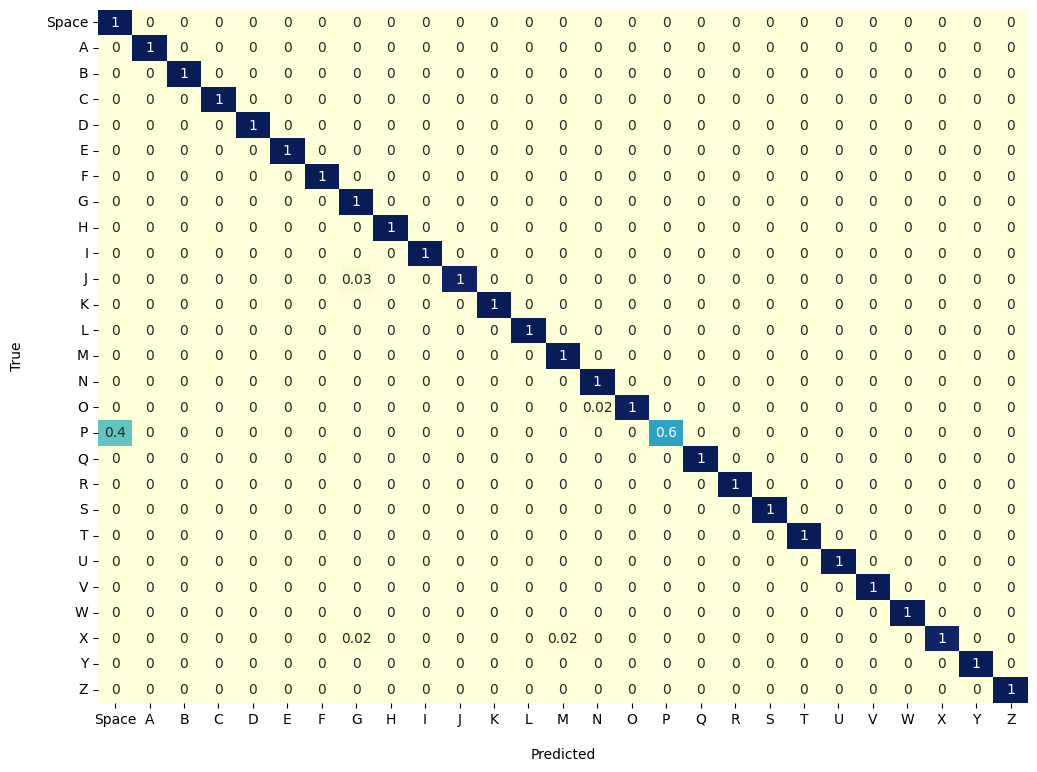

In [21]:
# plotting the confusion matrix
ConfusionMatrix(ds_test, layers=very_best_layer, save=save_fig)

### Lets create some raster plots

In [22]:
# plotting the network activity
NetworkActivity(ds_test, layers=very_best_layer, save=save_fig)

ValueError: not enough values to unpack (expected 5, got 3)